### Preparing data for region-based analysis

* Ref. for VAR https://stats.stackexchange.com/questions/235039/statsmodels-clarification-on-varp-results-attribute-results-forecast-interva
* Ref. for VAR http://www.statsmodels.org/dev/vector_ar.html
* Ref. for IRA http://www.statsmodels.org/dev/vector_ar.html?highlight=impulse
* Ref. for SARIMAX http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
* Good ref in time series http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/


In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import xuleta as xu
from scipy import stats
from functools import reduce
import os
month_names = pd.date_range(start='2016-01-01', periods=12, freq='MS').strftime('%b')

fout = '/Users/denismariano/pcloud/0NEWPROJ/plots/'#mac
fout = '/home/denis/pcloud/0NEWPROJ/plots/'
print(plt.style.available)
plt.style.use('seaborn-paper') #seaborn-paper

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


['fivethirtyeight', 'dark_background', 'seaborn-paper', 'seaborn-muted', 'seaborn-poster', 'seaborn-whitegrid', 'fast', 'seaborn-bright', 'Solarize_Light2', 'seaborn-colorblind', 'tableau-colorblind10', 'grayscale', 'seaborn-talk', 'seaborn-pastel', 'seaborn-darkgrid', '_classic_test', 'ggplot', 'seaborn-white', 'seaborn-deep', 'classic', 'seaborn-ticks', 'seaborn-notebook', 'bmh', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn']


In [2]:
# REMEMBER TO COMPARE THIS GROUPS WITH THE HCC GROUPS
regions = [41004, 41005, 41007, 41008, 41009, 41010, 41011, 41012, 41013, 41014, 41015, 41019, 
           41020, 41021, 41022, 41023, 41024, 41027, 41028, 41029, 41030, 42003, 43005,  43008, 
           43009, 43010, 43011, 43012, 43017]

grouped = [[41019,41020, 41021], #ce-PR
           [41007, 41008, 41009, 41010, 41011, 41012, 41013, 41014, 41015], #cn-PR
           [41004, 41005,41022, 41023, 41024], #cw-PR
           [41027, 41028, 41029, 41030, 42003], #sw-PR
           [43005,  43008,43009, 43010, 43011, 43012, 43017]] #nw-RS

groupnames = ['ce-PR', 'cn-PR', 'cw-PR', 'nw-RS', 'sw-PR']

In [3]:
def piv_table(var,lista,resample='M'):
    region_var = weightaverage(var,lista)
    region_var = pd.DataFrame(region_var)
    region_var.columns = ['values']
    region_var = region_var.resample('M').mean()

    region_var['year'] = region_var.index.year
    region_var['month'] = region_var.index.month
    region_var_piv = region_var.pivot(index='year', columns='month', values='values')
    region_var_piv.columns = month_names
    return region_var_piv

def weightaverage(var,region_number,area):
    '''
        var (pandas DataFrame): dataset containing the variable, either extracted from SQL or CSV, or the z-score of it
        region_number (int): group number (from grouped, in this case)
        area (float): threshold for minimum area to be considered for a municipality to be included in the weight average
    '''

    #area threshold -> I HAVE TO VERIFY WHAT THESE AREAS MEAN IN THE MAP

    l = list(aux[(aux['microrregi'].isin(grouped[region_number])) & (aux['area']> area)].geocodig_m)
    a = aux[aux['geocodig_m'].isin(l)]
    a['w'] = a.area/sum(a.area)
    a = a[['geocodig_m','w']]
    a.index = a.geocodig_m
    a.drop("geocodig_m",inplace=True,axis=1)
    a = a.T
    var_aw = pd.DataFrame(var[a.columns].values*a.values, columns=a.columns,index=var[a.columns].index)
    var_final = var_aw.sum(axis=1,skipna=True)
    var_final.index = pd.DatetimeIndex(var_final.index)
    print('A total of %d municipalities were considered' %var_aw.shape[1])
    return(var_final)

In [4]:
%%time
# MODIS ET
et = pd.read_csv("../SQL/drought_consultas_br_et.csv").pivot_table(index="acquisition",
                   columns="geocodig_m",values="mean").interpolate()

# MODIS LAI
lai = pd.read_csv("../SQL/drought_consultas_br_lai.csv").pivot_table(index="acquisition",
                   columns="geocodig_m",values="mean").interpolate()

#FILTERED NDVI
ndvi = pd.read_csv("../SQL/drought_consultas_br_ndvi.csv").pivot_table(index="acquisition",
                   columns="geocodig_m",values="mean").interpolate()

# ESI
esi = pd.read_csv("../SQL/drought_consultas_br_esi.csv").pivot_table(index="acquisition",
                   columns="geocodig_m",values="mean").interpolate()

esir = pd.read_csv("../SQL/drought_consultas_br_esi_regioes.csv").pivot_table(index="acquisition",
                   columns="subgrupo2",values="mean").interpolate()

esirc = pd.read_csv("../SQL/drought_consultas_br_esi_regioes_crop.csv").pivot_table(index="acquisition",
                   columns="subgrupo2",values="mean").interpolate()

# PREC CHIRPS

zprec = pd.read_csv("../SQL/drought_consultas_br_sul_chirps_zscore.csv").pivot_table(index="acquisition",
                   columns="geocodig_m",values="mean").interpolate()

prec = pd.read_csv("../SQL/drought_consultas_br_sul_chirps_prec.csv").pivot_table(index="acquisition",
                   columns="geocodig_m",values="mean").interpolate()


# GLEAM SM Root abs
smrootabs = pd.read_csv("../SQL/drought_consultas_br_sm_root_abs_region.csv").pivot_table(index="acquisition",
                   columns="subgrupo2",values="mean").interpolate()

# GLEAM SM Root anom
smrootanom = pd.read_csv("../SQL/drought_consultas_br_sm_root_anom_region.csv").pivot_table(index="acquisition",
                   columns="subgrupo2",values="mean").interpolate()

# GLEAM SM surface abs
smsurfabs = pd.read_csv("../SQL/drought_consultas_br_sm_surf_abs_region.csv").pivot_table(index="acquisition",
                   columns="subgrupo2",values="mean").interpolate()

# GLEAM SM surface anom
smsurfanom = pd.read_csv("../SQL/drought_consultas_br_sm_surf_anom_region.csv").pivot_table(index="acquisition",
                   columns="subgrupo2",values="mean").interpolate()


smrootabs.index = pd.DatetimeIndex(smrootabs.index)
smrootanom.index = pd.DatetimeIndex(smrootanom.index)
smsurfabs.index = pd.DatetimeIndex(smsurfabs.index)
smsurfanom.index = pd.DatetimeIndex(smsurfanom.index)
esir.index = pd.DatetimeIndex(esir.index)
esirc.index = pd.DatetimeIndex(esirc.index)

#CROP AREAS  
aux = pd.read_csv("../SQL/drought_consultas_br_aux_big_sul_crop.csv")

# LIST OF MUNICIPALITIES, MESO, MICROregions
sulmuni = pd.read_csv("../SQL/sul_muni.csv")
sulmuni.drop(["sigla","nome_muni","muni"],axis=1,inplace=True)

CPU times: user 7.88 s, sys: 266 ms, total: 8.15 s
Wall time: 8.15 s


**A t this point, GLEAM data is already given in regions (not agro). I am wondering if I should re-extract the other data to regions (either crop areas or just regions). **
* MODIS data definitely have to be extracted by crop mask
* CHIRPS data definitely by area (region)
* ESI data is tricky, I should try by crop regionalized

In [5]:
#MERGING data: aux with soy_null occurrence... kinda useless
aux = pd.merge(aux, sulmuni[["soy_null","geocodig_m"]], on='geocodig_m')
aux = aux[aux["soy_null"]<1].drop("soy_null",axis=1)

In [6]:
#???
lista = [4102703.0, 4103602.0, 4124103.0]
pd.options.mode.chained_assignment = None #error omit
a = aux[aux['geocodig_m'].isin(lista)].groupby("geocodig_m").sum()
a

,microrregi,area
geocodig_m,,
4102703,123048,2517.818024
4103602,369144,4089.357875
4124103,164064,1701.234461


### Let's organize the datasets by region

In [7]:
# CONVERTING Municipals to regionals
def grouping(var,thresh=15000):
    globals()['{}r'.format(var)] = pd.DataFrame()
    for i,j in enumerate(groupnames):
        globals()['{}r'.format(var)][j] = weightaverage(var,i,thresh)
    return globals()['{}r'.format(var)]

In [8]:
ndvir = grouping(ndvi)
lair = grouping(lai)
etr = grouping(et)
#esir2 = grouping(esi,5000) #or just use esir (already loaded)
zprecr = grouping(zprec)
precr = grouping(prec)

#Z-score
zndvir = xu.zscore(ndvir,index=True)
zlair = xu.zscore(lair,index=True)
zetr = xu.zscore(etr,index=True)

A total of 59 municipalities were considered
A total of 65 municipalities were considered
A total of 86 municipalities were considered
A total of 51 municipalities were considered
A total of 51 municipalities were considered
A total of 59 municipalities were considered
A total of 65 municipalities were considered
A total of 86 municipalities were considered
A total of 51 municipalities were considered
A total of 51 municipalities were considered
A total of 59 municipalities were considered
A total of 65 municipalities were considered
A total of 86 municipalities were considered
A total of 51 municipalities were considered
A total of 51 municipalities were considered
A total of 59 municipalities were considered
A total of 65 municipalities were considered
A total of 86 municipalities were considered
A total of 51 municipalities were considered
A total of 51 municipalities were considered
A total of 59 municipalities were considered
A total of 65 municipalities were considered
A total of

/home/denis/pcloud/mypy/xuleta.py:695: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  mean=pd.groupby(df,by=[df.index.dayofyear]).aggregate(np.nanmean)
/home/denis/pcloud/mypy/xuleta.py:696: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  std= pd.groupby(df,by=[df.index.dayofyear]).aggregate(np.nanstd)
/home/denis/pcloud/mypy/xuleta.py:695: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  mean=pd.groupby(df,by=[df.index.dayofyear]).aggregate(np.nanmean)
/home/denis/pcloud/mypy/xuleta.py:696: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  std= pd.groupby(df,by=[df.index.dayofyear]).aggregate(np.nanstd)
/home/denis/pcloud/mypy/xuleta.py:695: FutureWarning: pd.groupby() is 

#### The dataframes we have are:
* **ndvir**: NDVI extracted for crops within the municipalities and grouped into 5 regions (**crops**)
* **etr**: MODIS ET extracted for crops within the municipalities and grouped into 5 regions (**crops**)
* **lair**:LAI extracted for crops within the municipalities and grouped into 5 regions (**crops**)
* **esir**: ESI extracted for regions;
* **esir2**: ESI extracted for municipalities and weighted averaged into regions
* **esirc**: ESI extracted for regions' crops (**crops**)
* **zprecr**: Z-scores for precipitation
* **precr**: Precipitation absolute values
* **zndvir**: Z-scores for NDVI
* **zlair**: Z-scores for LAI
* **zetr**: Z-scores for MODIS ET
* **smrootabs**: Root-zone soil moisture for regions
* **smrootabs**: Root-zone soil moisture anomalies for regions
* **smsurabs**: Surface soil moisture for regions
* **smsurfabs**: Surface soil moisture anomalies for regions

### Exploratory plots

In [9]:
print(groupnames)
print(plt.style.available)

plt.style.use('classic') 

['ce-PR', 'cn-PR', 'cw-PR', 'nw-RS', 'sw-PR']
['fivethirtyeight', 'dark_background', 'seaborn-paper', 'seaborn-muted', 'seaborn-poster', 'seaborn-whitegrid', 'fast', 'seaborn-bright', 'Solarize_Light2', 'seaborn-colorblind', 'tableau-colorblind10', 'grayscale', 'seaborn-talk', 'seaborn-pastel', 'seaborn-darkgrid', '_classic_test', 'ggplot', 'seaborn-white', 'seaborn-deep', 'classic', 'seaborn-ticks', 'seaborn-notebook', 'bmh', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn']


### Some exploratory findings when considering only **anomalies**
* **Precipitation and soil** moisture have a good match
* **Root zone and surface** are pretty much the same -- Gotta choose one.
* **NDVI and LAI** are close, the decision is based on my approach for the paper
    - If I want to use one of them as a *post hoc* information, NDVI might be better due to higher resolution
    - However, if the idea is to decouple variables for IRA, LAI is (according to Martha), less dependent on ET (than GPP, what about NDVI?)
* **Evapotranspiation** is complicated:
    - ESI and MODIS ET have periods of good and bad match
        - They are usually OK, but in nw-RS and sw-PR the match is slightly worse
    - **I HAVE TO ASSESS** if the good vs bad match has to do with the season.

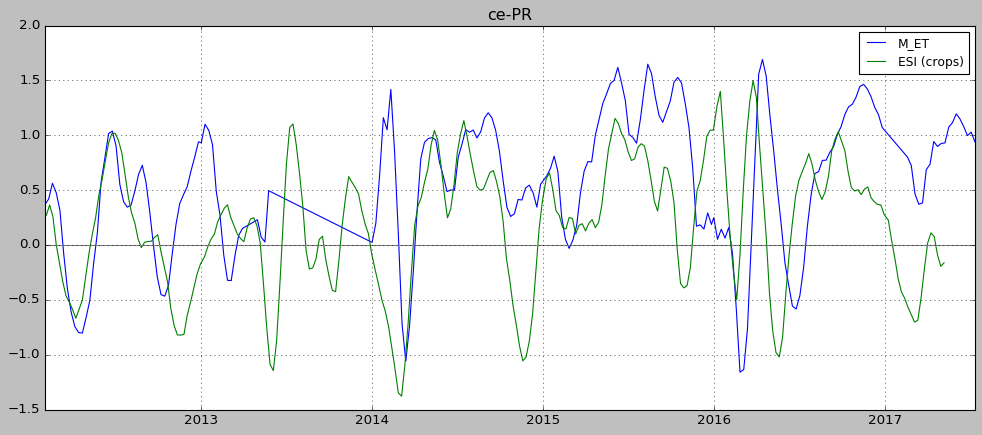

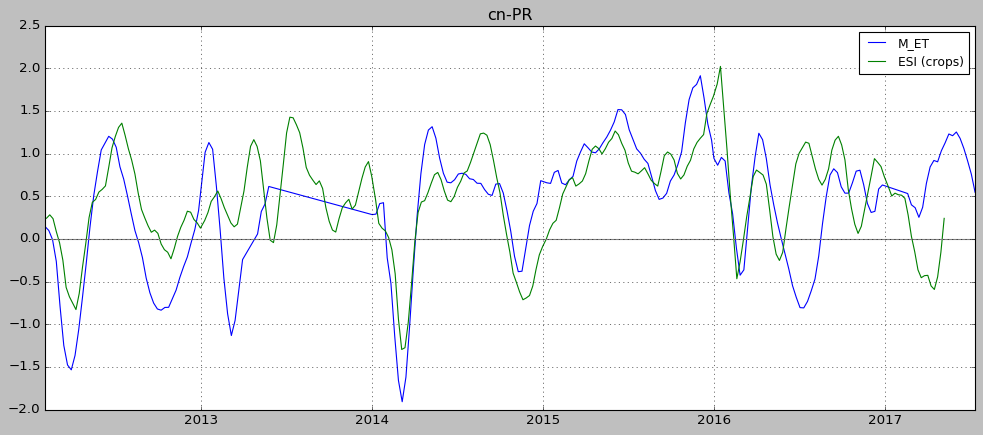

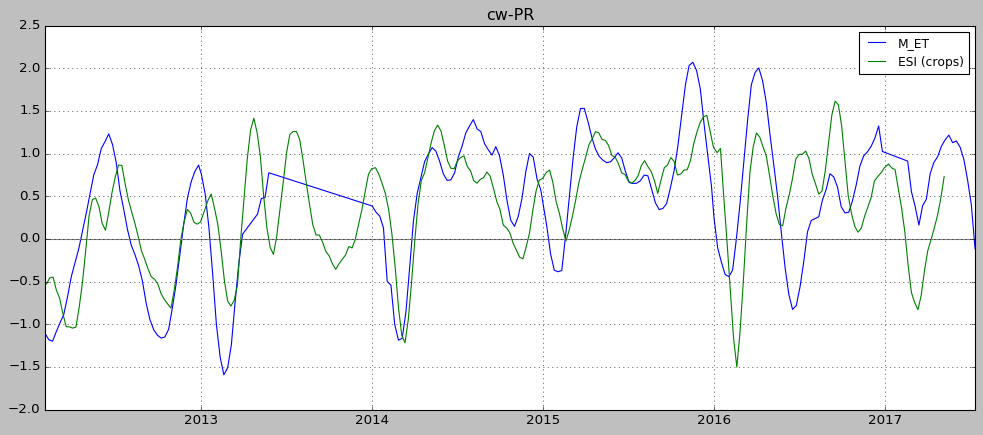

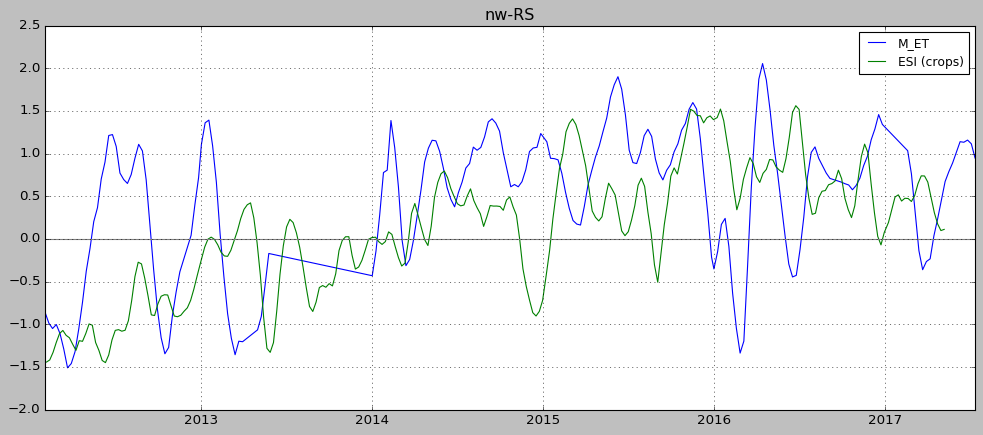

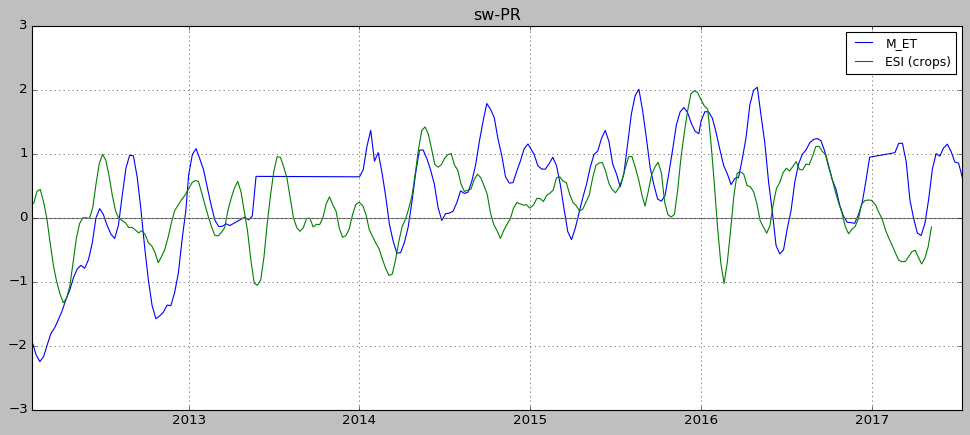

In [10]:
d1 = '2012'
d2 = '2018'
w = 5
# ['ce-PR', 'cn-PR', 'cw-PR', 'nw-RS', 'sw-PR']
r = 0
#----------
for r in range(5):
    plt.figure(figsize=(15,6))

    # Biomass
    #plt.plot(zndvir[groupnames[r]].loc[d1:d2].rolling(w).mean(),label='M_NDVI')
    #plt.plot(zlair[groupnames[r]].loc[d1:d2].rolling(w).mean(),label='M_LAI')

    # ET
    plt.plot(zetr[groupnames[r]].loc[d1:d2].rolling(w).mean(),label='M_ET')
    plt.plot(esirc[groupnames[r]].loc[d1:d2].rolling(w).mean(),label='ESI (crops)')
    #######plt.plot(esir[groupnames[r]].loc[d1:d2].rolling(w).mean(),label='ESI')

    # SM
    #plt.plot(smrootanom[groupnames[r]].loc[d1:d2].rolling(w).mean(),label='RZSM', color='brown', lw=3,alpha=0.4)
    #plt.plot(smsurfanom[groupnames[r]].loc[d1:d2].rolling(w).mean(),label='Surf SM')

    # Precipitation
    #plt.plot(zprecr[groupnames[r]].loc[d1:d2].rolling(w).mean(),label='Precip')

    plt.axhline(y=0, color='grey');plt.title(groupnames[r]);plt.grid();plt.legend(fontsize=11,loc='best');plt.show();plt.close()

## GOTTA PLAY WITH DOUBLE Y-AXIS to compare variables (not in anomalies)

### VAR
http://www.statsmodels.org/dev/vector_ar.html

In [11]:
from statsmodels.tsa.api import *
import statsmodels.api as sm

Index(['ce-PR', 'cn-PR', 'cw-PR', 'nw-RS', 'sw-PR'], dtype='object', name='subgrupo2')

In [12]:
# USING ANOMALIES
dates = ['2003-08','2016-12']

def construirZ(reg,dates):

    n = zlair[reg].loc[dates[0]:dates[1]].to_frame()
    e = esirc[reg].loc[dates[0]:dates[1]].to_frame()
    me = zetr[reg].loc[dates[0]:dates[1]].to_frame()
    sr = smrootanom[reg].loc[dates[0]:dates[1]].to_frame()
    p = zprecr[reg].loc[dates[0]:dates[1]].to_frame()
    
    dfs = [n,e,me,sr,p]
    final = reduce(lambda left,right: pd.merge(left,right, how='outer',
                                               right_index=True,left_index=True), dfs)
    final.columns = [['LAI','ESI','M_ET','RZSM','ZPrec']]
    final = final.interpolate('values',limit_direction='both')
    return final

# USING ANOMALIES


def construir(reg,dates):

    l = lair[reg].loc[dates[0]:dates[1]].to_frame()
    n = ndvir[reg].loc[dates[0]:dates[1]].to_frame()/10000
    e = esirc[reg].loc[dates[0]:dates[1]].to_frame()
    me = etr[reg].loc[dates[0]:dates[1]].to_frame()
    sr = smrootabs[reg].loc[dates[0]:dates[1]].to_frame()
    p = precr[reg].loc[dates[0]:dates[1]].to_frame()
    
    dfs = [l,n,e,me,sr,p]
    final = reduce(lambda left,right: pd.merge(left,right, how='outer',
                                               right_index=True,left_index=True), dfs)
    final.columns = [['LAI','NDVI','ESI','M_ET','RZSM','Prec']]
    final = final.interpolate('values',limit_direction='both')
    return final

In [14]:
#We can resample to weeks or not
r0 = construir('ce-PR',dates).resample('W').mean()
r1 = construir('cn-PR',dates).resample('W').mean()
r2 = construir('cw-PR',dates).resample('W').mean()
r3 = construir('nw-RS',dates).resample('W').mean()
r4 = construir('sw-PR',dates).resample('W').mean()

### Decomposing time-series using absolute values
* I can use the **residuals** to indentify the bad years for LAI and NDVI
    - it looks like NDVI is better to identify the bad years
* NEXT???

In [19]:
variavel = 'LAI'
x0 = seasonal_decompose(pd.Series(r0[variavel]))
x1 = seasonal_decompose(pd.Series(r1[variavel]))
x2 = seasonal_decompose(pd.Series(r2[variavel]))
x3 = seasonal_decompose(pd.Series(r3[variavel]))
x4 = seasonal_decompose(pd.Series(r4[variavel]))
decomps = [x0,x1,x2,x3,x4]

ValueError: Wrong number of items passed 1, placement implies 700

In [20]:
variavel = 'LAI'
x0 = seasonal_decompose(r0[variavel])
x1 = seasonal_decompose(r1[variavel])
x2 = seasonal_decompose(r2[variavel])
x3 = seasonal_decompose(r3[variavel])
x4 = seasonal_decompose(r4[variavel])
decomps = [x0,x1,x2,x3,x4]

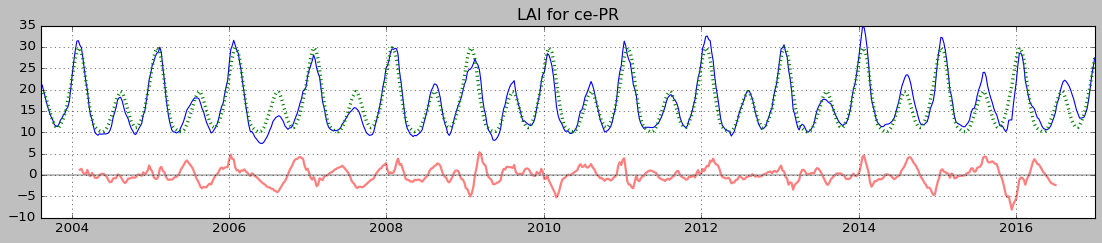

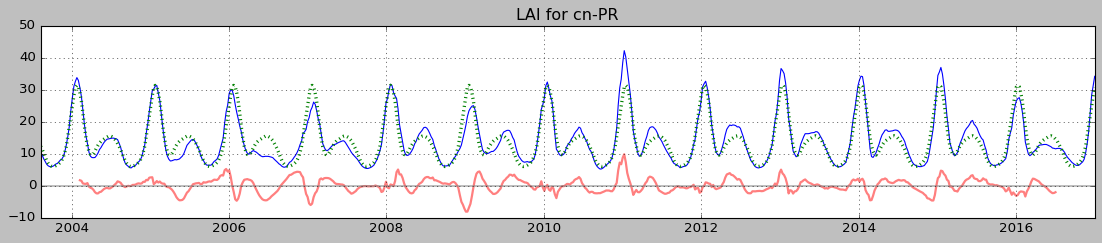

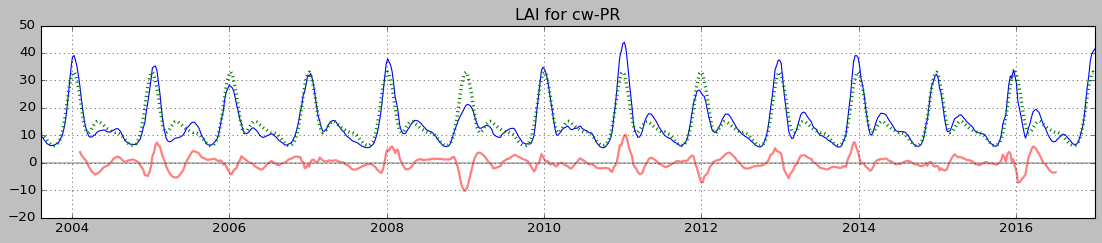

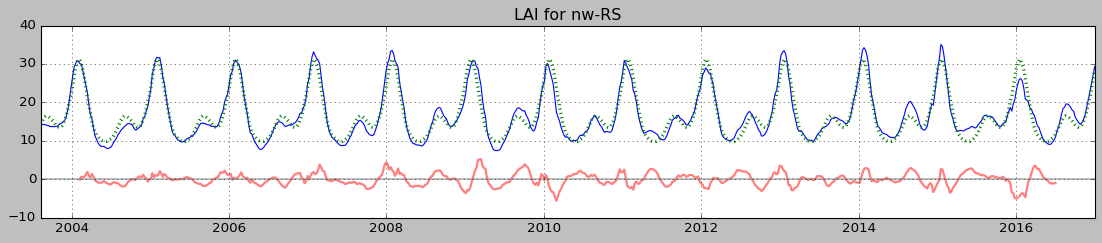

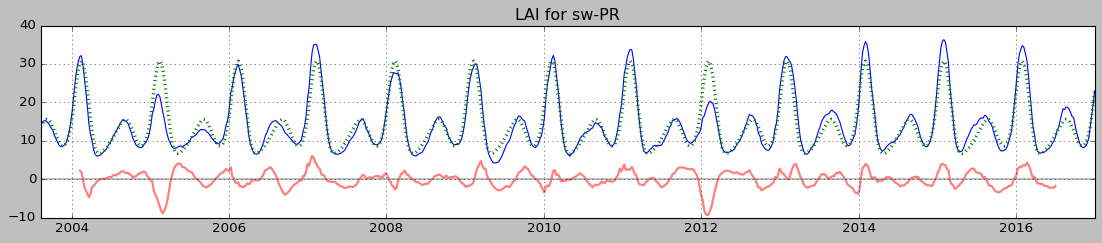

In [21]:
#PLOTTING THE DATA
for i,j in zip(decomps,groupnames):
    plt.figure(figsize=(17,3))
    plt.plot(i.observed,label='observed')
    plt.plot(i.seasonal+i.observed.mean(),lw=3,label='seasonal',linestyle=":")
    plt.plot(i.resid,color='red',lw=2,alpha=0.5,label='residual')
    
    plt.axhline(y=0,lw=1.8,alpha=0.5,color='grey')
    plt.title("%s for %s" %(variavel,j));plt.grid()
    plt.show();plt.close()

In [19]:
#We have to restrict data to growing season
# two methods
#r0[(r0.index.dayofyear > 275) | (r0.index.dayofyear < 55) ]

#r0[r0.index.to_series().dt.month.isin([10,11,12,1,2])]

#Filter for season
r0 = r0[r0.index.to_series().dt.month.isin([10,11,12,1,2])]
r1 = r1[r1.index.to_series().dt.month.isin([10,11,12,1,2])]
r2 = r2[r2.index.to_series().dt.month.isin([10,11,12,1,2])]
r3 = r3[r3.index.to_series().dt.month.isin([10,11,12,1,2])]
r4 = r4[r4.index.to_series().dt.month.isin([10,11,12,1,2])]

In [22]:
m0 = VAR(r0)
m1 = VAR(r1)
m2 = VAR(r2)
m3 = VAR(r3)
m4 = VAR(r4)

m0.select_order(10)
m1.select_order(10)
m2.select_order(10)
m3.select_order(10)
m4.select_order(10)

In [23]:
ml = int(np.round((12*len(r0)/100)**.25,0)+1)

f0 = m0.fit(maxlags=ml,ic='bic')
f1 = m1.fit(maxlags=ml,ic='bic')
f2 = m2.fit(maxlags=ml,ic='bic')
f3 = m3.fit(maxlags=ml,ic='bic')
f4 = m4.fit(maxlags=ml,ic='bic')

#f0.summary()

In [24]:
# IMPULSE RESPONSE FUNCTION
l = 8 #weekly periods

irf0 = f0.irf(l)
irf1 = f1.irf(l)
irf2 = f2.irf(l)
irf3 = f3.irf(l)
irf4 = f4.irf(l)

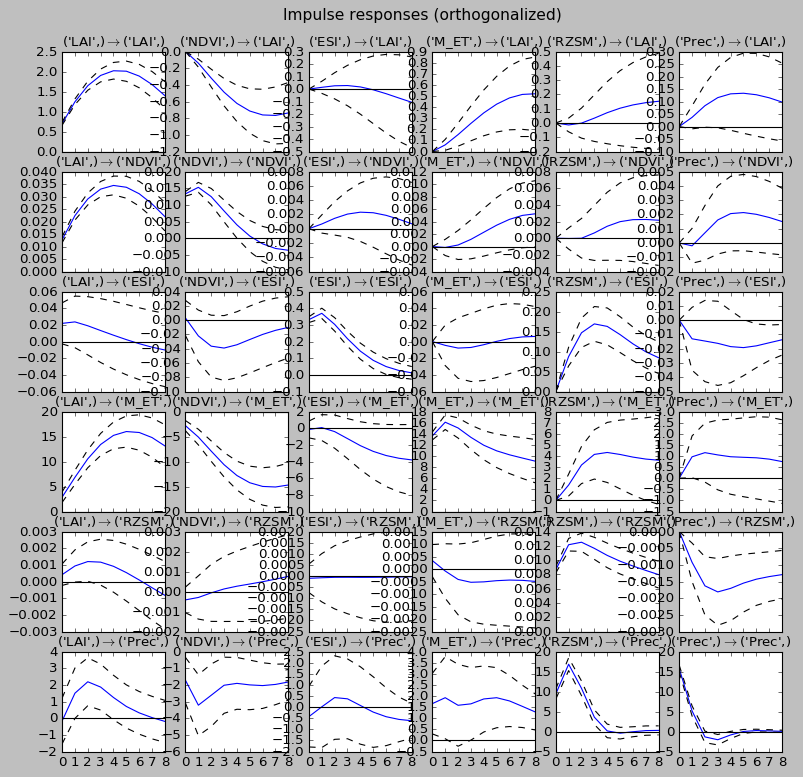

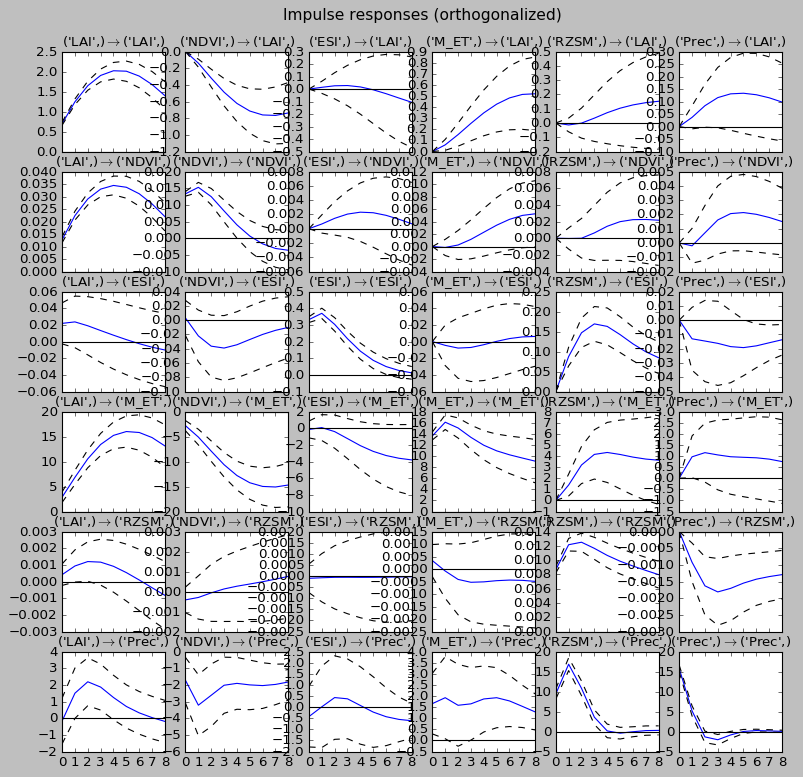

In [25]:
#GROWING SEASON
irf0.plot(l)

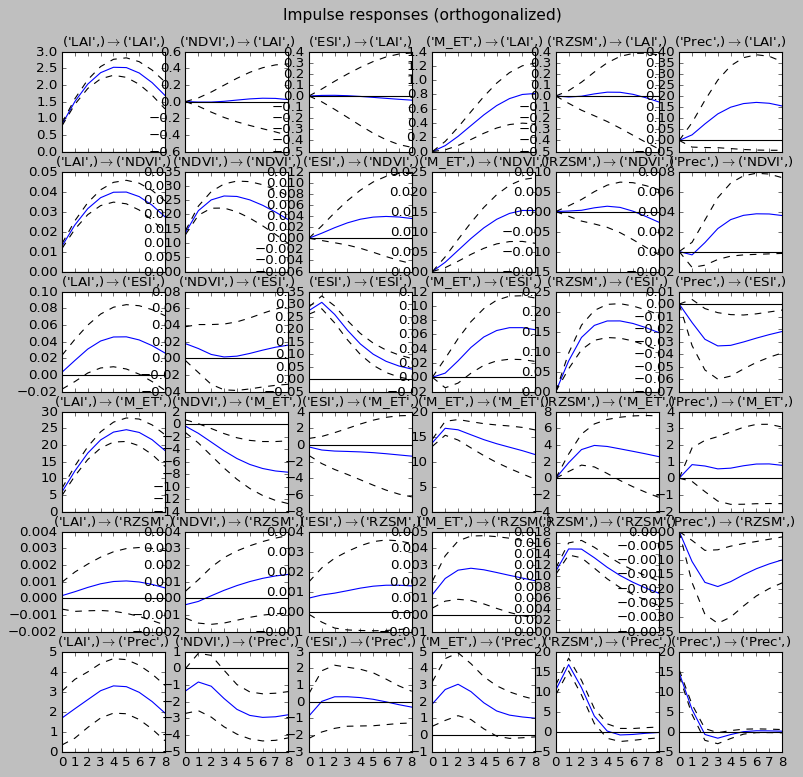

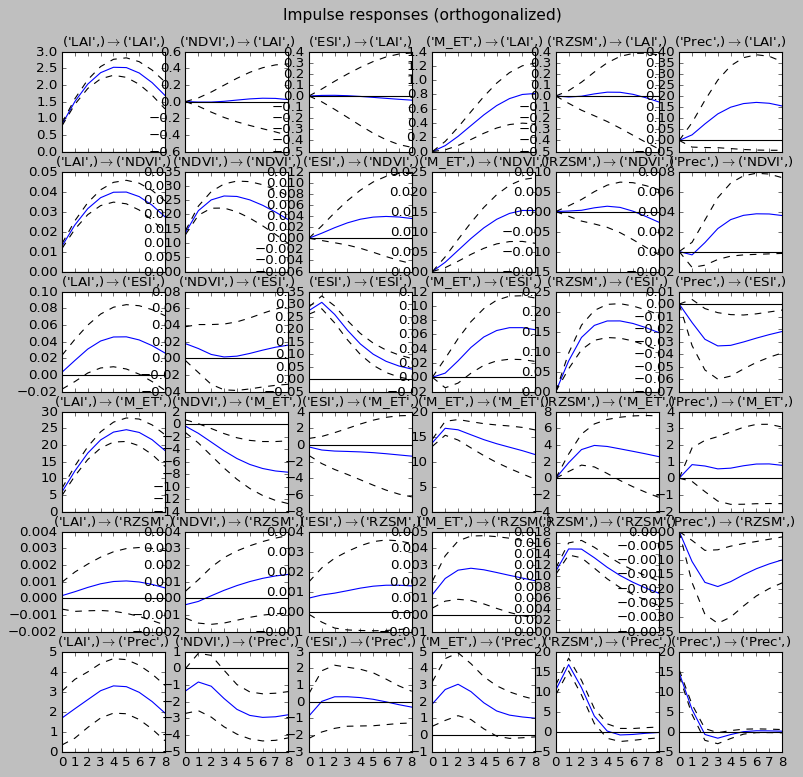

In [26]:
irf1.plot(l)

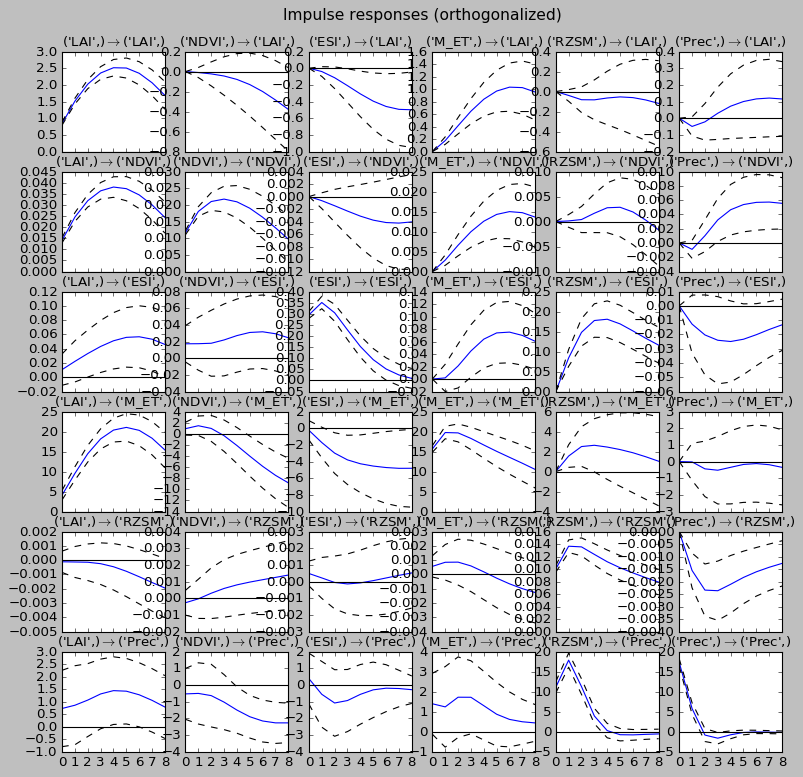

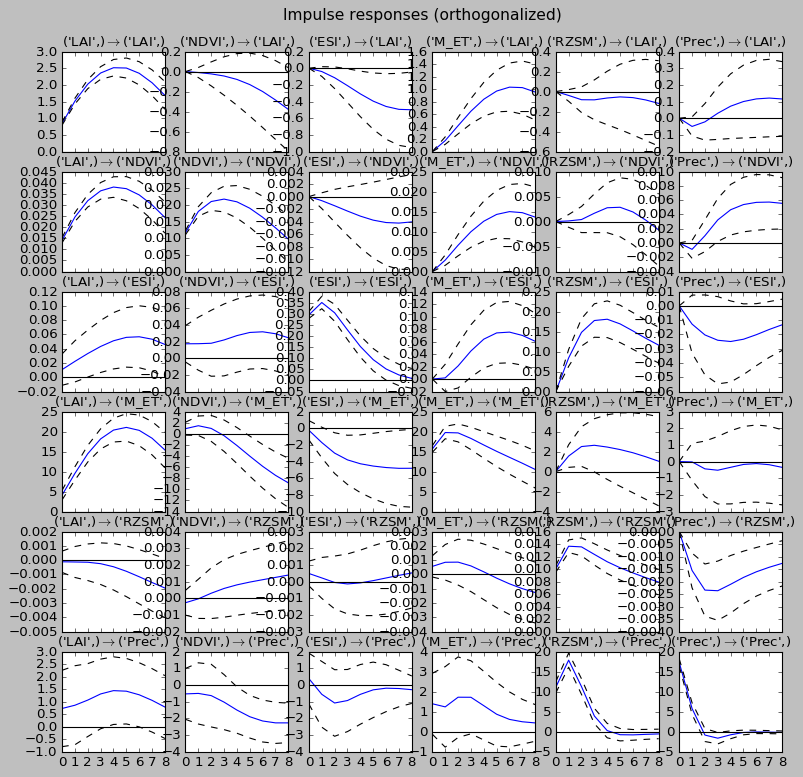

In [27]:
irf2.plot(l)

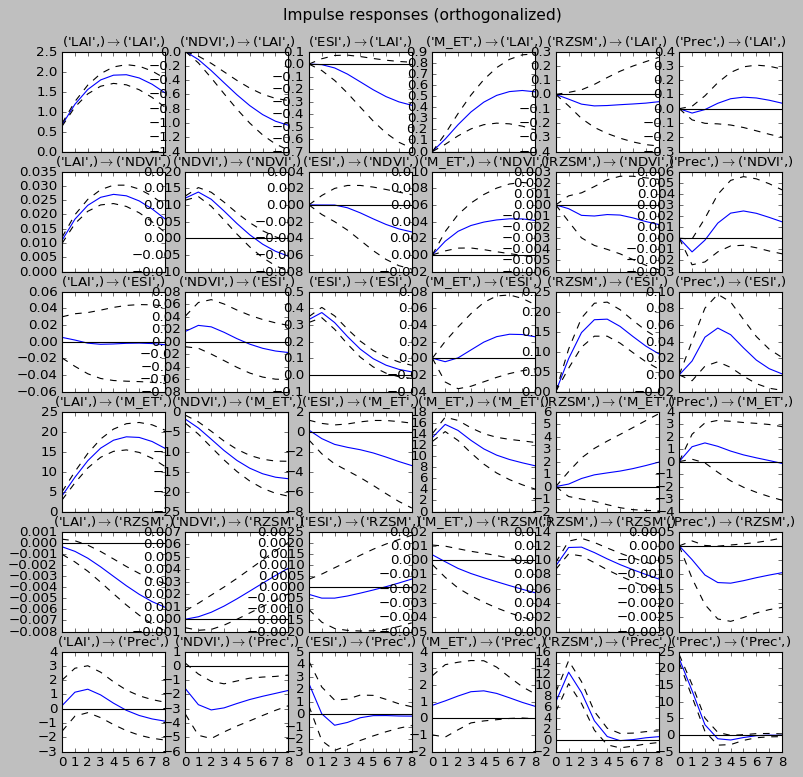

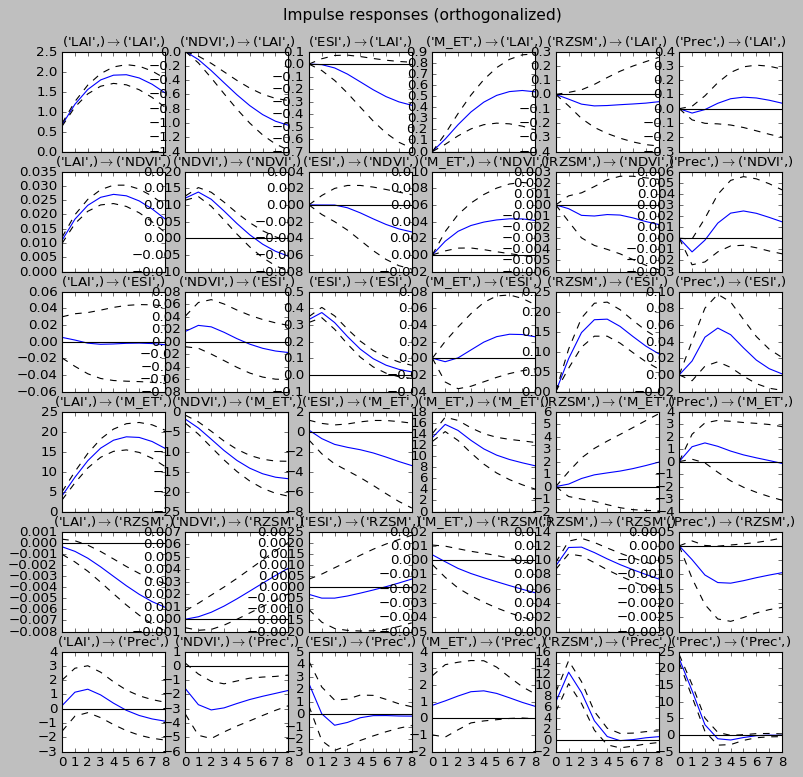

In [28]:
irf3.plot(l)

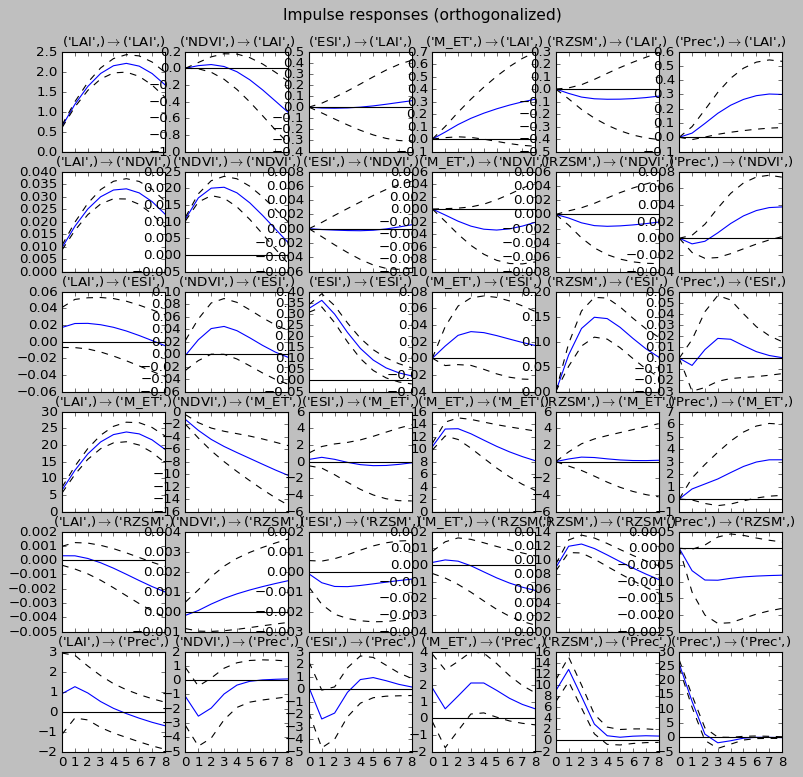

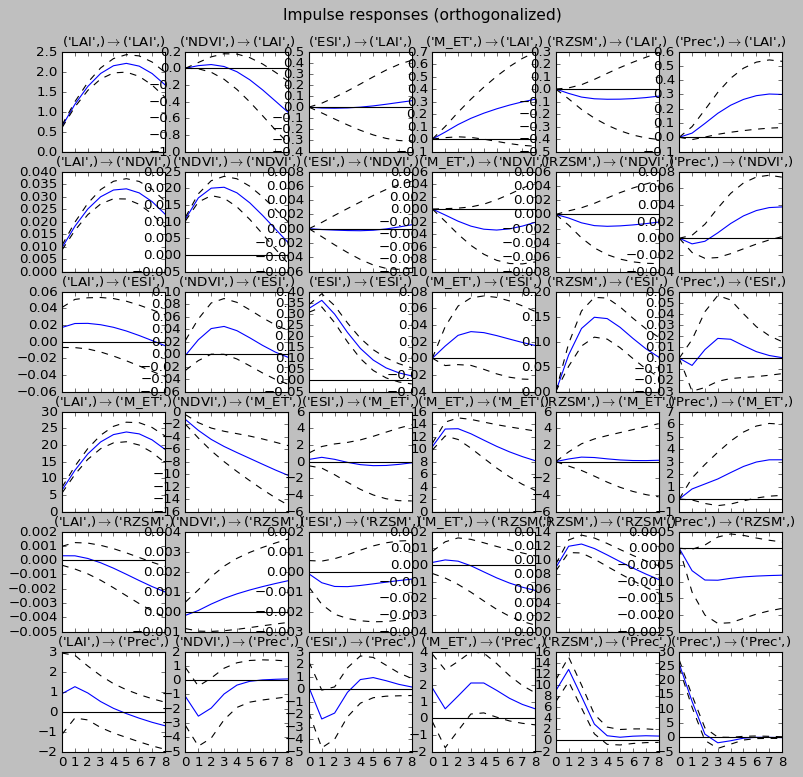

In [29]:
irf4.plot(l)

In [30]:
irf0.plot(orth=True,response='LAI')
plt.show()

ValueError: 'LAI' is not in list

In [ ]:
#Rootzone
    plt.figure(figsize=(16,5)) #para 2 plots, 12,5
    plt.subplot(1,3,1)
    plt.imshow(a)
    plt.title("Root-zone %s" %(i[-12:-4]))
    plt.colorbar();plt.clim(-2,2)
    
    #Surface
    plt.subplot(1,3,2)
    plt.imshow(b)
    plt.title("Surface %s" %(j[-11:-4]))
    plt.colorbar();plt.clim(-2,2)
    
    # RZSM - SM
    plt.subplot(1,3,3)
    plt.imshow(b-a) #try anything
    plt.title("Surf - RZ %s" %(j[-11:-4]))
    plt.colorbar();plt.clim(-0.3,0.3)    
    
    plt.show();plt.close()

### impulse response analysis
Lutkepohl 262(274)

In [ ]:
l = 10
irf0 = fm0.irf(l)

In [ ]:
plt.plot(irfc.orth_irfs[:,0,1], lw=1.5, label='ND6+CERN', color='black')
plt.show()

In [ ]:
pl

### A BIG PLOT

In [ ]:
#ORTHOGONALIZED

plt.style.use('seaborn-paper')#bmh
#https://matplotlib.org/devdocs/gallery/style_sheets/style_sheets_reference.html
#fivethirtyeight
#ggplot
params = {'legend.fontsize': 11,
         #'axes.labelsize': 'x-large',
         'axes.titlesize':12,
         'xtick.labelsize':12,
         'ytick.labelsize':12,
         'lines.linewidth':1,
         'figure.titlesize':16,
         #'axes.titleweight': 'bold' 
         }
plt.rcParams.update(params)

f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(12,7),sharex=True)#, sharey=True

#IRFS
ax1.plot(irf1.orth_irfs[:,0,1], lw=1.5, label='ND1')
ax1.plot(irf2.orth_irfs[:,0,1], lw=1.5, label='ND2')
ax1.plot(irf3.orth_irfs[:,0,1], lw=1.5, label='ND3')
ax1.plot(irf4.orth_irfs[:,0,1], lw=1.5, label='ND4')
ax1.plot(irf5.orth_irfs[:,0,1], lw=1.5, label='ND5')
ax1.plot(irfc.orth_irfs[:,0,1], lw=1.5, label='ND6+CERN', color='black')
ax1.plot(irfp.orth_irfs[:,0,1], lw=1.5, label='PI1+PI2')
ax1.plot(irfb.orth_irfs[:,0,1], lw=1.5, label='BA1+BA2', color='#0cb6ba')
ax1.axhline(y=0, color='grey', alpha=.75)
ax1.set_title('a) zGPP -> ESI', x=.05, y=.90, ha='left')
#ax1.legend(loc=2, ncol=1, frameon=True, fancybox=True, lw=1.5, labelspacing=0.1)

ax2.plot(irf1.orth_irfs[:,0,2], lw=1.5, label='ND1')
ax2.plot(irf2.orth_irfs[:,0,1], lw=1.5, label='ND2')
ax2.plot(irf3.orth_irfs[:,0,1], lw=1.5, label='ND3')
ax2.plot(irf4.orth_irfs[:,0,1], lw=1.5, label='ND4')
ax2.plot(irf5.orth_irfs[:,0,1], lw=1.5, label='ND5')
ax2.plot(irfc.orth_irfs[:,0,2], lw=1.5, label='ND6+CERN', color='black')
ax2.plot(irfp.orth_irfs[:,0,1], lw=1.5, label='PI1+PI2')
ax2.plot(irfb.orth_irfs[:,0,2], lw=1.5, label='BA1+BA2', color='#0cb6ba')
ax2.axhline(y=0, color='grey', alpha=.75)
ax2.set_title('b) zAlbedo -> ESI', x=.05, y=.90, ha='left')
#ax2.legend(loc=2, ncol=1, frameon=True, fancybox=True, lw=1.5, labelspacing=0.1)

ax3.plot(irf1.orth_irfs[:,0,3], lw=1.5, label='ND1')
ax3.plot(irf2.orth_irfs[:,0,1], lw=1.5, label='ND2')
ax3.plot(irf3.orth_irfs[:,0,1], lw=1.5, label='ND3')
ax3.plot(irf4.orth_irfs[:,0,1], lw=1.5, label='ND4')
ax3.plot(irf5.orth_irfs[:,0,1], lw=1.5, label='ND5')
ax3.plot(irfc.orth_irfs[:,0,3], lw=1.5, label='ND6+CERN', color='black')
ax3.plot(irfp.orth_irfs[:,0,1], lw=1.5, label='PI1+PI2')
ax3.plot(irfb.orth_irfs[:,0,3], lw=1.5, label='BA1+BA2', color='#0cb6ba')
ax3.axhline(y=0, color='grey', alpha=.75)
ax3.set_title('c) zPrec -> ESI', x=.05, y=.90, ha='left')
#ax3.legend(loc=2, ncol=1, frameon=True, fancybox=True, lw=1.5, labelspacing=0.1)

#Cum_IRFS
ax4.plot(irf1.orth_cum_effects[:,0,1], lw=1.5, label='ND1')
ax4.plot(irf2.orth_cum_effects[:,0,1], lw=1.5, label='ND2')
ax4.plot(irf3.orth_cum_effects[:,0,1], lw=1.5, label='ND3')
ax4.plot(irf4.orth_cum_effects[:,0,1], lw=1.5, label='ND4')
ax4.plot(irf5.orth_cum_effects[:,0,1], lw=1.5, label='ND5')
ax4.plot(irfc.orth_cum_effects[:,0,1], lw=1.5, label='ND6+CERN', color='black')
ax4.plot(irfp.orth_cum_effects[:,0,1], lw=1.5, label='PI1+PI2')
ax4.plot(irfb.orth_cum_effects[:,0,1], lw=1.5, label='BA1+BA2', color='#0cb6ba')
ax4.axhline(y=0, color='grey', alpha=.75)
ax4.set_title('d) zGPP -> ESI', x=.05, y=.90, ha='left')
ax4.set_xlabel('period (week)', fontsize=12)

#ax4.legend(loc=2, ncol=1, frameon=True, fancybox=True, lw=1.5, labelspacing=0.1)
ax5.plot(irf1.orth_cum_effects[:,0,2], lw=1.5, label='ND1')
ax5.plot(irf2.orth_cum_effects[:,0,1], lw=1.5, label='ND2')
ax5.plot(irf3.orth_cum_effects[:,0,1], lw=1.5, label='ND3')
ax5.plot(irf4.orth_cum_effects[:,0,1], lw=1.5, label='ND4')
ax5.plot(irf5.orth_cum_effects[:,0,1], lw=1.5, label='ND5')
ax5.plot(irfc.orth_cum_effects[:,0,2], lw=1.5, label='ND6+CERN', color='black')
ax5.plot(irfp.orth_cum_effects[:,0,1], lw=1.5, label='PI1+PI2')
ax5.plot(irfb.orth_cum_effects[:,0,2], lw=1.5, label='BA1+BA2', color='#0cb6ba')
ax5.axhline(y=0, color='grey', alpha=.75)
ax5.set_title('e) zAlbedo -> ESI', x=.05, y=.90, ha='left')
ax5.legend(loc='best', ncol=1, frameon=True, fancybox=True,  labelspacing=0.1).get_frame().set_alpha(0.7)
ax5.set_xlabel('period (week)', fontsize=12)

ax6.plot(irf1.orth_cum_effects[:,0,3], lw=1.5, label='ND1')
ax6.plot(irf2.orth_cum_effects[:,0,1], lw=1.5, label='ND2')
ax6.plot(irf3.orth_cum_effects[:,0,1], lw=1.5, label='ND3')
ax6.plot(irf4.orth_cum_effects[:,0,1], lw=1.5, label='ND4')
ax6.plot(irf5.orth_cum_effects[:,0,1], lw=1.5, label='ND5')
ax6.plot(irfc.orth_cum_effects[:,0,3], lw=1.5, label='ND6+CERN', color='black')
ax6.plot(irfp.orth_cum_effects[:,0,1], lw=1.5, label='PI1+PI2')
ax6.plot(irfb.orth_cum_effects[:,0,3], lw=1.5, label='BA1+BA2', color='#0cb6ba')
ax6.axhline(y=0, color='grey', alpha=.75)
ax6.set_title('f) zPrec -> ESI', x=.05, y=.90, ha='left')
ax6.set_xlabel('period (week)', fontsize=12)

#ax6.legend(loc=2, ncol=1, frameon=True, fancybox=True, lw=1.5, labelspacing=0.1)

f.subplots_adjust(hspace=0.1,wspace=0.275)
#f.savefig(fout+'IRF_cumIRF.pdf',bbox_inches='tight', transparent=True)
plt.show()
plt.close()

In [ ]:
lr = [nd1,nd2,nd3,nd4,nd5,cern,pi1+pi2,ba1+ba2]
lrn = ['nd1','nd2','nd3','nd4','nd5','nd6+cern','pi1+pi2','ba1+ba2']
dates = ['2002-08','2016-07']
w = 30
x = .82
y = .88
a = 0.05

plt.style.use('seaborn-whitegrid')
params = {'legend.fontsize': 13,
         #'axes.labelsize': 'x-large',
         'axes.titlesize':15,
         'xtick.labelsize':13,
         'ytick.labelsize':13,
         'lines.linewidth':1.2,
         'figure.titlesize':20,
         #'axes.titleweight': 'bold' 
         }
plt.rcParams.update(params)

f, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4,2, figsize=(10,14),sharex=True, sharey=True)

#
ax1.plot(weightaverage(zprec,lr[0]).loc[dates[0]:dates[1]].rolling(w).mean(), label='zPREC')
ax1.plot(weightaverage(zgpp,lr[0]).loc[dates[0]:dates[1]].rolling(w).mean(), label='zGPP')
ax1.plot(weightaverage(esi,lr[0]).loc[dates[0]:dates[1]].rolling(w).mean(), label='ESI')
ax1.plot(weightaverage(zalbedo,lr[0]).loc[dates[0]:dates[1]].rolling(w).mean(), color='orange',label='zAlbedo')
ax1.set_title(lrn[0].upper(), x=x, y=y)
ax1.axhline(y=0, color='grey')
ax1.axvspan('2002-10','2012-01',alpha=a, color='blue')
ax1.axvspan('2012-01','2017-05',alpha=a, color='red')
ax1.set_xlim('2002-10','2016-08')
ax1.legend(loc=2, ncol=1, frameon=True, fancybox=True, labelspacing=0.1).get_frame().set_alpha(0.7)

ax2.plot(weightaverage(zprec,lr[1]).loc[dates[0]:dates[1]].rolling(w).mean(), label='zPREC')
ax2.plot(weightaverage(zgpp,lr[1]).loc[dates[0]:dates[1]].rolling(w).mean(), label='zGPP')
ax2.plot(weightaverage(esi,lr[1]).loc[dates[0]:dates[1]].rolling(w).mean(), label='ESI')
ax2.plot(weightaverage(zalbedo,lr[1]).loc[dates[0]:dates[1]].rolling(w).mean(), color='orange',label='zAlbedo')
ax2.set_title(lrn[1].upper(), x=x, y=y)
ax2.axhline(y=0, color='grey')
ax2.axvspan('2002-10','2012-01',alpha=a, color='blue')
ax2.axvspan('2012-01','2017-05',alpha=a, color='red')

ax3.plot(weightaverage(zprec,lr[2]).loc[dates[0]:dates[1]].rolling(w).mean(), label='zPREC')
ax3.plot(weightaverage(zgpp,lr[2]).loc[dates[0]:dates[1]].rolling(w).mean(), label='zGPP')
ax3.plot(weightaverage(esi,lr[2]).loc[dates[0]:dates[1]].rolling(w).mean(), label='ESI')
ax3.plot(weightaverage(zalbedo,lr[2]).loc[dates[0]:dates[1]].rolling(w).mean(), color='orange',label='zAlbedo')
ax3.set_title(lrn[2].upper(), x=x, y=y)
ax3.axhline(y=0, color='grey')
ax3.axvspan('2002-10','2012-01',alpha=a, color='blue')
ax3.axvspan('2012-01','2017-05',alpha=a, color='red')

ax4.plot(weightaverage(zprec,lr[3]).loc[dates[0]:dates[1]].rolling(w).mean(), label='zPREC')
ax4.plot(weightaverage(zgpp,lr[3]).loc[dates[0]:dates[1]].rolling(w).mean(), label='zGPP')
ax4.plot(weightaverage(esi,lr[3]).loc[dates[0]:dates[1]].rolling(w).mean(), label='ESI')
ax4.plot(weightaverage(zalbedo,lr[3]).loc[dates[0]:dates[1]].rolling(w).mean(), color='orange',label='zAlbedo')
ax4.set_title(lrn[3].upper(), x=x, y=y)
ax4.axhline(y=0, color='grey')
ax4.axvspan('2002-10','2012-01',alpha=a, color='blue')
ax4.axvspan('2012-01','2017-05',alpha=a, color='red')

ax5.plot(weightaverage(zprec,lr[4]).loc[dates[0]:dates[1]].rolling(w).mean(), label='zPREC')
ax5.plot(weightaverage(zgpp,lr[4]).loc[dates[0]:dates[1]].rolling(w).mean(), label='zGPP')
ax5.plot(weightaverage(esi,lr[4]).loc[dates[0]:dates[1]].rolling(w).mean(), label='ESI')
ax5.plot(weightaverage(zalbedo,lr[4]).loc[dates[0]:dates[1]].rolling(w).mean(), color='orange',label='zAlbedo')
ax5.set_title(lrn[4].upper(), x=x, y=y)
ax5.axhline(y=0, color='grey')
ax5.axvspan('2002-10','2012-01',alpha=a, color='blue')
ax5.axvspan('2012-01','2017-05',alpha=a, color='red')

ax6.plot(weightaverage(zprec,lr[5]).loc[dates[0]:dates[1]].rolling(w).mean(), label='zPREC')
ax6.plot(weightaverage(zgpp,lr[5]).loc[dates[0]:dates[1]].rolling(w).mean(), label='zGPP')
ax6.plot(weightaverage(esi,lr[5]).loc[dates[0]:dates[1]].rolling(w).mean(), label='ESI')
ax6.plot(weightaverage(zalbedo,lr[5]).loc[dates[0]:dates[1]].rolling(w).mean(), color='orange',label='zAlbedo')
ax6.set_title(lrn[5].upper(), x=x, y=y)
ax6.axhline(y=0, color='grey')
ax6.axvspan('2002-10','2012-01',alpha=a, color='blue')
ax6.axvspan('2012-01','2017-05',alpha=a, color='red')

df = weightaverage(zprec,lista=lr[6])
df[df > 2.8] = np.nan
ax7.plot(df.loc[dates[0]:dates[1]].rolling(w).mean(), label='zPREC')
ax7.plot(weightaverage(zgpp,lr[6]).loc[dates[0]:dates[1]].rolling(w).mean(), label='zGPP')
ax7.plot(weightaverage(esi,lr[6]).loc[dates[0]:dates[1]].rolling(w).mean(), label='ESI')
ax7.plot(weightaverage(zalbedo,lr[6]).loc[dates[0]:dates[1]].rolling(w).mean(), color='orange',label='zAlbedo')
ax7.set_title(lrn[6].upper(), x=x, y=y)
ax7.axhline(y=0, color='grey')
ax7.axvspan('2002-10','2012-01',alpha=a, color='blue')
ax7.axvspan('2012-01','2017-05',alpha=a, color='red')

ax8.plot(weightaverage(zprec,lr[7]).loc[dates[0]:dates[1]].rolling(w).mean(), label='zPREC')
ax8.plot(weightaverage(zgpp,lr[7]).loc[dates[0]:dates[1]].rolling(w).mean(), label='zGPP')
ax8.plot(weightaverage(esi,lr[7]).loc[dates[0]:dates[1]].rolling(w).mean(), label='ESI')
ax8.plot(weightaverage(zalbedo,lr[7]).loc[dates[0]:dates[1]].rolling(w).mean(), color='orange',label='zAlbedo')
ax8.set_title(lrn[7].upper(), x=x, y=y)
ax8.axhline(y=0, color='grey')
ax8.axvspan('2002-10','2012-01',alpha=a, color='blue')
ax8.axvspan('2012-01','2017-05',alpha=a, color='red')

f.subplots_adjust(hspace=0.065,wspace=0.025)
f.savefig(fout+'gpp_esi_prec.pdf',bbox_inches='tight', transparent=True)
plt.show()
plt.close()

In [ ]:
fevdc = rc.fevd(10)
fevd1 = r1.fevd(10)
fevd2 = r2.fevd(10)
fevd3 = r3.fevd(10)
fevdp = rp.fevd(10)
fevdb = rb.fevd(10)
#print(fevdc.summary())
#print(fevd1.summary())
#print(fevdb.summary())

In [ ]:
fevdp.plot()
plt.show()

### Granger causality
- Does zAlbedo cause ESI?
- Does zGPP cause ESI?
- Does ESI cause zGPP?

In [ ]:
rb.test_causality('ESI','zAlbedo',kind='f', signif=0.05)

In [ ]:
rb.test_causality('ESI','zGPP',kind='f', signif=0.05)

In [ ]:
rb.test_causality('ESI','zPrec',kind='f', signif=0.05)

In [ ]:
rb.test_causality('zPrec','ESI',kind='f', signif=0.05)